# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from maddpg_agent import Agent,ReplayBuffer
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
BUFFER_SIZE=int(1e6)
BATCH_SIZE=128
GAMMA=0.99     
TAU=0.1
LR_ACTOR=5e-4     
LR_CRITIC=1e-3      
WEIGHT_DECAY=0.000000001
RANDOM_SEED=0
Shared_Memory = ReplayBuffer(buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE)

Agents = [Agent(
        state_size=state_size,
        action_size=action_size,
        buffer_size=BUFFER_SIZE,
        batch_size=BATCH_SIZE,    
        gamma=GAMMA,  
        memory = Shared_Memory,
        tau=TAU,
        lr_actor=LR_ACTOR,       
        lr_critic=LR_CRITIC,       
        weight_decay=WEIGHT_DECAY,
        random_seed=RANDOM_SEED) for _ in range(num_agents)]

In [8]:
def load_weights(agents):
    for i, agent in enumerate(agents):
        agent.actor_local.load_state_dict(torch.load('checkpoint_actor{}.pth'.format(i)))
        agent.critic_local.load_state_dict(torch.load('checkpoint_critic{}.pth'.format(i)))
def save_weights(agents):
    for i, agent in enumerate(agents):
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor{}.pth'.format(i))
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic{}.pth'.format(i))

In [9]:
#load_weights(Agents)

  0%|          | 3/2000 [00:01<26:11,  1.27it/s]

Episode 4	Average Score: 0.00 Best_score 0.00

  0%|          | 5/2000 [00:03<28:03,  1.18it/s]

Episode 5	Average Score: 0.00 Best_score 0.00

  0%|          | 6/2000 [00:11<1:44:27,  3.14s/it]

Episode 6	Average Score: 0.02 Best_score 0.10

  0%|          | 7/2000 [00:15<1:51:08,  3.35s/it]

Episode 7	Average Score: 0.01 Best_score 0.10

  0%|          | 8/2000 [00:19<1:53:42,  3.42s/it]

Episode 8	Average Score: 0.01 Best_score 0.10

  0%|          | 9/2000 [00:22<1:56:01,  3.50s/it]

Episode 9	Average Score: 0.01 Best_score 0.10

  0%|          | 10/2000 [00:26<1:59:19,  3.60s/it]

Episode 10	Average Score: 0.01 Best_score 0.10

  1%|          | 11/2000 [00:30<2:02:06,  3.68s/it]

Episode 11	Average Score: 0.01 Best_score 0.10

  1%|          | 12/2000 [00:34<2:01:42,  3.67s/it]

Episode 12	Average Score: 0.01 Best_score 0.10

  1%|          | 13/2000 [00:37<2:03:02,  3.72s/it]

Episode 13	Average Score: 0.01 Best_score 0.10

  1%|          | 14/2000 [00:41<2:04:51,  3.77s/it]

Episode 14	Average Score: 0.01 Best_score 0.10

  1%|          | 15/2000 [00:50<2:51:32,  5.19s/it]

Episode 15	Average Score: 0.01 Best_score 0.10

  1%|          | 16/2000 [00:54<2:40:16,  4.85s/it]

Episode 16	Average Score: 0.01 Best_score 0.10

  1%|          | 17/2000 [00:57<2:27:36,  4.47s/it]

Episode 17	Average Score: 0.01 Best_score 0.10

  1%|          | 18/2000 [01:06<3:09:15,  5.73s/it]

Episode 18	Average Score: 0.02 Best_score 0.10

  1%|          | 19/2000 [01:14<3:32:34,  6.44s/it]

Episode 19	Average Score: 0.02 Best_score 0.10

  1%|          | 20/2000 [01:23<3:53:20,  7.07s/it]

Episode 20	Average Score: 0.02 Best_score 0.10

  1%|          | 21/2000 [01:31<4:05:10,  7.43s/it]

Episode 21	Average Score: 0.03 Best_score 0.10

  1%|          | 22/2000 [01:39<4:12:31,  7.66s/it]

Episode 22	Average Score: 0.03 Best_score 0.10

  1%|          | 23/2000 [01:48<4:20:13,  7.90s/it]

Episode 23	Average Score: 0.03 Best_score 0.10

  1%|          | 24/2000 [02:02<5:22:46,  9.80s/it]

Episode 24	Average Score: 0.04 Best_score 0.10

  1%|▏         | 25/2000 [02:10<5:07:51,  9.35s/it]

Episode 25	Average Score: 0.04 Best_score 0.10

  1%|▏         | 26/2000 [02:14<4:12:50,  7.69s/it]

Episode 26	Average Score: 0.04 Best_score 0.10

  1%|▏         | 27/2000 [02:18<3:33:33,  6.49s/it]

Episode 27	Average Score: 0.04 Best_score 0.10

  1%|▏         | 28/2000 [02:26<3:52:04,  7.06s/it]

Episode 28	Average Score: 0.04 Best_score 0.10

  1%|▏         | 29/2000 [02:34<4:01:52,  7.36s/it]

Episode 29	Average Score: 0.04 Best_score 0.10

  2%|▏         | 30/2000 [02:38<3:26:40,  6.29s/it]

Episode 30	Average Score: 0.04 Best_score 0.10

  2%|▏         | 31/2000 [02:52<4:41:09,  8.57s/it]

Episode 31	Average Score: 0.04 Best_score 0.10

  2%|▏         | 32/2000 [03:01<4:45:38,  8.71s/it]

Episode 32	Average Score: 0.04 Best_score 0.10

  2%|▏         | 33/2000 [03:15<5:37:02, 10.28s/it]

Episode 33	Average Score: 0.04 Best_score 0.10

  2%|▏         | 34/2000 [03:43<8:35:33, 15.73s/it]

Episode 34	Average Score: 0.05 Best_score 0.30

  2%|▏         | 35/2000 [04:31<13:53:35, 25.45s/it]

Episode 35	Average Score: 0.06 Best_score 0.50

  2%|▏         | 36/2000 [04:45<11:58:24, 21.95s/it]

Episode 36	Average Score: 0.07 Best_score 0.50

  2%|▏         | 37/2000 [05:04<11:23:46, 20.90s/it]

Episode 37	Average Score: 0.07 Best_score 0.50

  2%|▏         | 38/2000 [05:32<12:33:30, 23.04s/it]

Episode 38	Average Score: 0.07 Best_score 0.50

  2%|▏         | 39/2000 [05:45<11:01:28, 20.24s/it]

Episode 39	Average Score: 0.08 Best_score 0.50

  2%|▏         | 40/2000 [06:04<10:41:16, 19.63s/it]

Episode 40	Average Score: 0.08 Best_score 0.50

  2%|▏         | 41/2000 [06:38<13:01:50, 23.95s/it]

Episode 41	Average Score: 0.08 Best_score 0.50

  2%|▏         | 42/2000 [06:46<10:28:43, 19.27s/it]

Episode 42	Average Score: 0.08 Best_score 0.50

  2%|▏         | 43/2000 [07:00<9:33:34, 17.59s/it] 

Episode 43	Average Score: 0.08 Best_score 0.50

  2%|▏         | 44/2000 [07:14<8:57:01, 16.47s/it]

Episode 44	Average Score: 0.08 Best_score 0.50

  2%|▏         | 45/2000 [07:32<9:11:51, 16.94s/it]

Episode 45	Average Score: 0.09 Best_score 0.50

  2%|▏         | 46/2000 [07:45<8:36:31, 15.86s/it]

Episode 46	Average Score: 0.09 Best_score 0.50

  2%|▏         | 47/2000 [08:09<9:52:24, 18.20s/it]

Episode 47	Average Score: 0.09 Best_score 0.50

  2%|▏         | 48/2000 [08:22<9:06:59, 16.81s/it]

Episode 48	Average Score: 0.09 Best_score 0.50

  2%|▏         | 49/2000 [08:30<7:41:32, 14.19s/it]

Episode 49	Average Score: 0.09 Best_score 0.50

  2%|▎         | 50/2000 [08:48<8:17:27, 15.31s/it]

Episode 50	Average Score: 0.09 Best_score 0.50

  3%|▎         | 51/2000 [09:32<12:53:14, 23.80s/it]

Episode 51	Average Score: 0.10 Best_score 0.50

  3%|▎         | 52/2000 [10:24<17:26:53, 32.25s/it]

Episode 52	Average Score: 0.11 Best_score 0.50

  3%|▎         | 53/2000 [11:26<22:20:11, 41.30s/it]

Episode 53	Average Score: 0.12 Best_score 0.60

  3%|▎         | 54/2000 [11:50<19:25:35, 35.94s/it]

Episode 54	Average Score: 0.12 Best_score 0.60

  3%|▎         | 55/2000 [13:30<29:51:29, 55.26s/it]

Episode 55	Average Score: 0.13 Best_score 0.90

  3%|▎         | 56/2000 [13:59<25:40:19, 47.54s/it]

Episode 56	Average Score: 0.13 Best_score 0.90

  3%|▎         | 57/2000 [14:59<27:38:31, 51.22s/it]

Episode 57	Average Score: 0.14 Best_score 0.90

  3%|▎         | 58/2000 [15:18<22:21:03, 41.43s/it]

Episode 58	Average Score: 0.14 Best_score 0.90

  3%|▎         | 59/2000 [17:24<36:02:06, 66.83s/it]

Episode 59	Average Score: 0.16 Best_score 1.19

  3%|▎         | 60/2000 [17:39<27:39:38, 51.33s/it]

Episode 60	Average Score: 0.16 Best_score 1.19

  3%|▎         | 61/2000 [19:49<40:17:22, 74.80s/it]

Episode 61	Average Score: 0.17 Best_score 1.19

  3%|▎         | 62/2000 [20:11<31:48:59, 59.10s/it]

Episode 62	Average Score: 0.17 Best_score 1.19

  3%|▎         | 63/2000 [21:46<37:34:03, 69.82s/it]

Episode 63	Average Score: 0.18 Best_score 1.19

  3%|▎         | 64/2000 [23:32<43:21:09, 80.61s/it]

Episode 64	Average Score: 0.19 Best_score 1.19

  3%|▎         | 65/2000 [24:39<41:13:07, 76.69s/it]

Episode 65	Average Score: 0.20 Best_score 1.19

  3%|▎         | 66/2000 [25:15<34:37:57, 64.47s/it]

Episode 66	Average Score: 0.20 Best_score 1.19

  3%|▎         | 67/2000 [25:40<28:17:26, 52.69s/it]

Episode 67	Average Score: 0.20 Best_score 1.19

  3%|▎         | 68/2000 [26:10<24:34:47, 45.80s/it]

Episode 68	Average Score: 0.20 Best_score 1.19

  3%|▎         | 69/2000 [26:25<19:30:13, 36.36s/it]

Episode 69	Average Score: 0.20 Best_score 1.19

  4%|▎         | 70/2000 [27:12<21:17:22, 39.71s/it]

Episode 70	Average Score: 0.20 Best_score 1.19

  4%|▎         | 71/2000 [27:35<18:39:34, 34.82s/it]

Episode 71	Average Score: 0.20 Best_score 1.19

  4%|▎         | 72/2000 [28:00<17:04:24, 31.88s/it]

Episode 72	Average Score: 0.20 Best_score 1.19

  4%|▎         | 73/2000 [28:25<15:57:18, 29.81s/it]

Episode 73	Average Score: 0.20 Best_score 1.19

  4%|▎         | 74/2000 [29:54<25:24:57, 47.51s/it]

Episode 74	Average Score: 0.21 Best_score 1.19

  4%|▍         | 75/2000 [30:45<25:54:49, 48.46s/it]

Episode 75	Average Score: 0.21 Best_score 1.19

  4%|▍         | 76/2000 [30:59<20:27:18, 38.27s/it]

Episode 76	Average Score: 0.21 Best_score 1.19

  4%|▍         | 77/2000 [32:38<30:05:49, 56.34s/it]

Episode 77	Average Score: 0.22 Best_score 1.19

  4%|▍         | 78/2000 [33:49<32:24:24, 60.70s/it]

Episode 78	Average Score: 0.23 Best_score 1.19

  4%|▍         | 79/2000 [34:40<30:52:21, 57.86s/it]

Episode 79	Average Score: 0.23 Best_score 1.19

  4%|▍         | 80/2000 [35:08<26:01:05, 48.78s/it]

Episode 80	Average Score: 0.23 Best_score 1.19

  4%|▍         | 81/2000 [35:38<23:05:15, 43.31s/it]

Episode 81	Average Score: 0.23 Best_score 1.19

  4%|▍         | 82/2000 [36:05<20:26:36, 38.37s/it]

Episode 82	Average Score: 0.23 Best_score 1.19

  4%|▍         | 83/2000 [36:13<15:32:47, 29.20s/it]

Episode 83	Average Score: 0.23 Best_score 1.19

  4%|▍         | 84/2000 [37:46<25:44:14, 48.36s/it]

Episode 84	Average Score: 0.24 Best_score 1.19

  4%|▍         | 85/2000 [37:59<20:02:44, 37.68s/it]

Episode 85	Average Score: 0.24 Best_score 1.19

  4%|▍         | 86/2000 [38:12<16:07:05, 30.32s/it]

Episode 86	Average Score: 0.24 Best_score 1.19

  4%|▍         | 87/2000 [38:36<15:03:38, 28.34s/it]

Episode 87	Average Score: 0.24 Best_score 1.19

  4%|▍         | 88/2000 [38:49<12:36:30, 23.74s/it]

Episode 88	Average Score: 0.23 Best_score 1.19

  4%|▍         | 89/2000 [40:01<20:23:20, 38.41s/it]

Episode 89	Average Score: 0.24 Best_score 1.19

  4%|▍         | 90/2000 [40:19<17:03:45, 32.16s/it]

Episode 90	Average Score: 0.24 Best_score 1.19

  5%|▍         | 91/2000 [43:31<42:29:38, 80.14s/it]

Episode 91	Average Score: 0.26 Best_score 1.90

  5%|▍         | 92/2000 [43:54<33:26:46, 63.11s/it]

Episode 92	Average Score: 0.26 Best_score 1.90

  5%|▍         | 93/2000 [45:53<42:16:47, 79.81s/it]

Episode 93	Average Score: 0.27 Best_score 1.90

  5%|▍         | 94/2000 [48:22<53:14:31, 100.56s/it]

Episode 94	Average Score: 0.28 Best_score 1.90

  5%|▍         | 95/2000 [50:06<53:42:34, 101.50s/it]

Episode 95	Average Score: 0.29 Best_score 1.90

  5%|▍         | 96/2000 [50:29<41:18:39, 78.11s/it] 

Episode 96	Average Score: 0.29 Best_score 1.90

  5%|▍         | 97/2000 [54:53<70:42:19, 133.76s/it]

Episode 97	Average Score: 0.31 Best_score 2.60

  5%|▍         | 98/2000 [59:16<91:07:08, 172.47s/it]

Episode 98	Average Score: 0.33 Best_score 2.60

  5%|▍         | 99/2000 [59:18<64:06:49, 121.42s/it]

Episode 99	Average Score: 0.33 Best_score 2.60

  5%|▌         | 100/2000 [59:45<49:06:02, 93.03s/it]

Episode 100	Average Score: 0.33


  5%|▌         | 101/2000 [1:04:06<75:46:17, 143.64s/it]

Episode 101	Average Score: 0.36 Best_score 2.60

  5%|▌         | 102/2000 [1:05:56<70:22:05, 133.47s/it]

Episode 102	Average Score: 0.37 Best_score 2.60

  5%|▌         | 103/2000 [1:09:00<78:17:04, 148.56s/it]

Episode 103	Average Score: 0.38 Best_score 2.60

  5%|▌         | 104/2000 [1:10:34<69:38:22, 132.23s/it]

Episode 104	Average Score: 0.39 Best_score 2.60

  5%|▌         | 105/2000 [1:15:03<91:07:13, 173.10s/it]

Episode 105	Average Score: 0.42 Best_score 2.60

  5%|▌         | 106/2000 [1:17:47<89:41:47, 170.49s/it]

Episode 106	Average Score: 0.43 Best_score 2.60

  5%|▌         | 107/2000 [1:18:01<64:55:14, 123.46s/it]

Episode 107	Average Score: 0.43 Best_score 2.60

  5%|▌         | 108/2000 [1:19:03<55:15:32, 105.14s/it]

Episode 108	Average Score: 0.44 Best_score 2.60

  5%|▌         | 109/2000 [1:19:58<47:17:33, 90.03s/it] 

Episode 109	Average Score: 0.44 Best_score 2.60

  6%|▌         | 110/2000 [1:20:38<39:20:11, 74.93s/it]

Episode 110	Average Score: 0.45 Best_score 2.60

  6%|▌         | 111/2000 [1:22:01<40:37:48, 77.43s/it]

Episode 111	Average Score: 0.46 Best_score 2.60

  6%|▌         | 112/2000 [1:22:09<29:43:15, 56.67s/it]

Episode 112	Average Score: 0.46 Best_score 2.60

  6%|▌         | 113/2000 [1:26:40<63:20:27, 120.84s/it]

Episode 113	Average Score: 0.48 Best_score 2.60

  6%|▌         | 114/2000 [1:26:53<46:21:16, 88.48s/it] 

Episode 114	Average Score: 0.48 Best_score 2.60

  6%|▌         | 115/2000 [1:27:06<34:35:25, 66.06s/it]

Episode 115	Average Score: 0.48 Best_score 2.60

  6%|▌         | 115/2000 [1:30:50<24:49:08, 47.40s/it]

Episode 116	Average Score: 0.51 Best_score 2.60
Environment solved in 116 episodes!	Average Score: 0.51


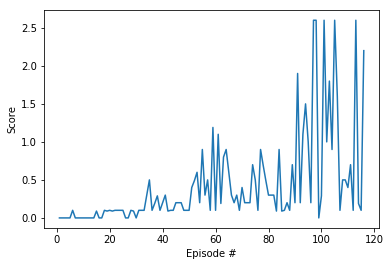

In [10]:
STOP_NOISE_AFTER_EP=300
env_info = env.reset(train_mode=True)[brain_name]
def maddpg(n_episodes=2000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0.0
    add_noise = True
    for i_episode in tqdm(range(1, n_episodes+1)):
        if i_episode > STOP_NOISE_AFTER_EP:
            add_noise = False
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent in Agents:
            agent.reset()
        scores_ep = np.zeros(num_agents)
        while True:
            actions = [agent.act(states[i], add_noise=add_noise) for i, agent in enumerate(Agents)]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for i, agent in enumerate(Agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            scores_ep += rewards
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        scores.append(max_score)
        if max_score > best_score:
            best_score = max_score
        print('\rEpisode {}\tAverage Score: {:.2f} Best_score {:.2f}'.format(i_episode, np.mean(scores_deque), best_score), end="")
        save_weights(Agents)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            save_weights(Agents)
            break
    return scores

scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test the Agent

In [11]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = [agent.act(states[i], add_noise=False) for i,agent in enumerate(Agents)]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 2.600000038743019
Score (max over agents) from episode 5: 2.7000000402331352


$\neq$